In [1]:
import data_process as process
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [3]:
### Load the bids and payloads CSV files ###

origin_bids_df = pd.read_csv("data/Eden_MEV-Boost_bid_20240404.csv") # MEV-Boost bids data from Eden Public Data
origin_payload_df = pd.read_csv("data/mev_blocks_19580000_to_19589999.csv") # MEV-Boost Winning Bid Data

# Check if matched_df already exists in the current namespace
if 'matched_df' not in locals():
    # Process the data if matched_df does not exist
    bids_df, payload_df = process.cleaning(origin_bids_df, origin_payload_df)
    bids_df, payload_df = process.transformation(bids_df, payload_df)
    matched_df, origin_matched_df = process.get_matched_df(bids_df, payload_df)
    
else:
    print("matched_df already exists. Skipping processing steps.")

Data cleaning has completed
Data transformation has completed
Amount of distinct block_number in bids_df: 1206
Amount of matched block_number in payload_df:  1036
Amount of distinct winner block_hash: 1036
Got matched_df (winner bids data)


# Duplicate Estimation

In [4]:
def plot_duplicate(df, title):
    block_hash_counts = df['block_hash'].value_counts()

    block_hash_counts_df = block_hash_counts.reset_index()
    block_hash_counts_df.columns = ['block_hash', 'count']
    
    distinct_block_hash = df['block_hash'].nunique()
    print(f"Distinct_block_hashs: {distinct_block_hash} in {title}'")
    
    mean_count = block_hash_counts_df['count'].mean()
    
    plt.figure(figsize=(12, 8))
    sns.histplot(block_hash_counts_df['count'], kde=False, bins=range(1, block_hash_counts_df['count'].max() + 1), color='skyblue', edgecolor='black')
    

    plt.title(f'Density Distribution of block_hash in {title}', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.xlim(0, 10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.text(0.5, 0.9, f'Mean: {mean_count:.2f}', horizontalalignment='center', 
             verticalalignment='center', transform=plt.gca().transAxes) # mean
    
    plt.savefig(f'graphs/Duplicates of block_hash in {title}.png')
    plt.show()

Distinct_block_hashs: 1506727 in All bids'


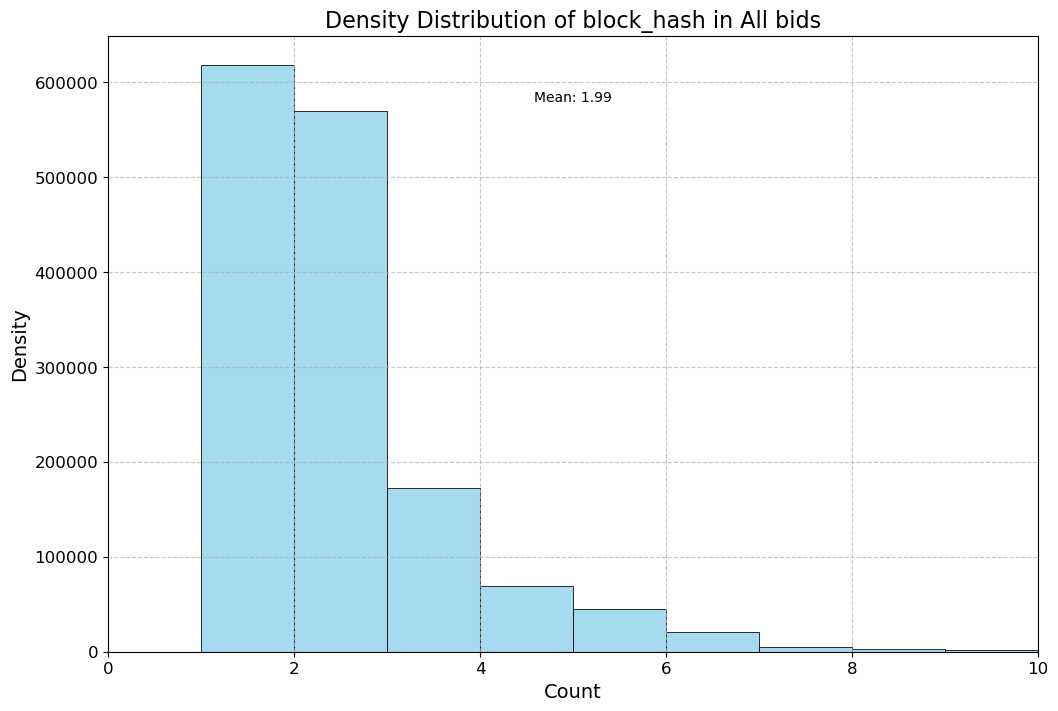

Distinct_block_hashs: 903 in Winner bids'


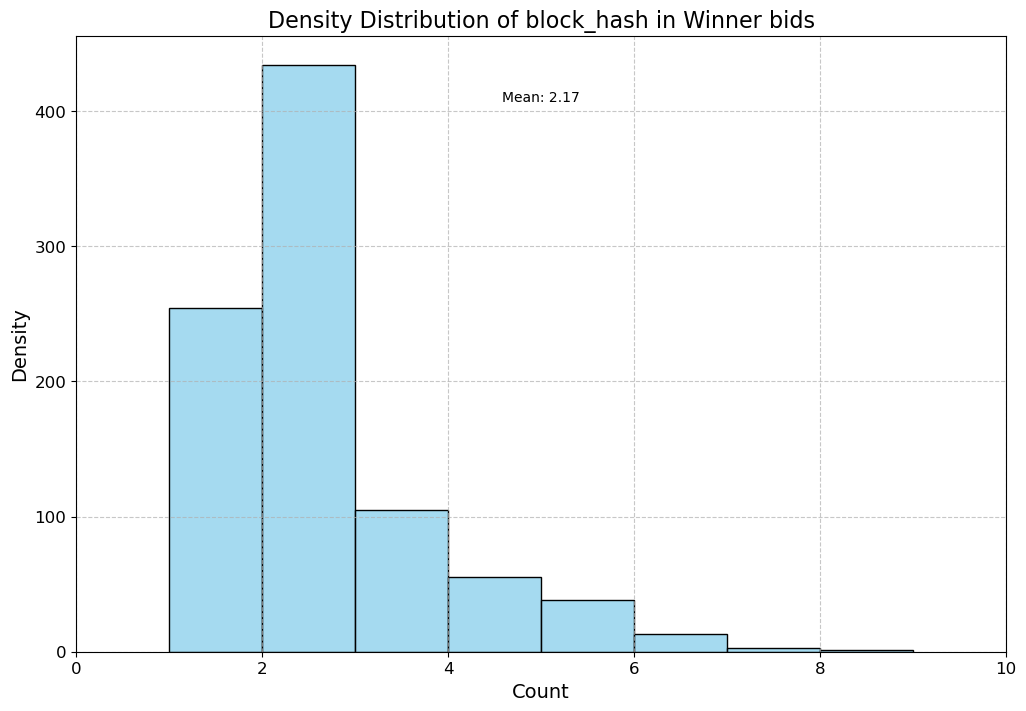

In [5]:
# Plot and display statistics for bids and payload data
plot_duplicate(origin_bids_df, 'All bids')#
plot_duplicate(origin_matched_df, 'Winner bids')#

# EDA Visualisation

In [6]:
### Remove outliers ###
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [7]:
### Plot the distribution graph for a variable ###
def sns_compare (name, df, v1, v2, v3, v4): # v is attribute name (str)
    df1 = remove_outliers(df, v1) # remove outliers
    df2 = remove_outliers(df, v2)
    df3 = remove_outliers(df, v3)
    df4 = remove_outliers(df, v4)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplot(2, 2, 1)
    sns.distplot(df1[v1], color='green')
    plt.subplot(2, 2, 2)
    sns.distplot(df2[v2], color='blue')
    plt.subplot(2, 2, 3)
    sns.distplot(df3[v3], color='orange')
    plt.subplot(2, 2, 4)
    sns.distplot(df4[v4], color='red')
    plt.tight_layout()
    plt.savefig(f'graphs/compare_{name} ({v1} {v2} {v3} {v4}) (no outlier).png')
    plt.show()
    
def sns_outlier (name, df, v1, v2, v3, v4): # v is attribute name (str)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplot(2, 2, 1)
    sns.distplot(df[v1], color='green')
    plt.subplot(2, 2, 2)
    sns.distplot(df[v2], color='blue')
    plt.subplot(2, 2, 3)
    sns.distplot(df[v3], color='orange')
    plt.subplot(2, 2, 4)
    sns.distplot(df[v4], color='red')
    plt.tight_layout()
    plt.savefig(f'graphs/compare_{name} ({v1} {v2} {v3} {v4}).png')
    plt.show()

In [8]:
### Compare 2 variables using scatter plot ###
def scatter (df, v1, v2, colour, name=''):
    a = df[v1]
    b = df[v2]

    plt.figure(figsize=(10, 6))
    plt.scatter(a, b, alpha=0.3, color=colour)
    plt.title(f'Scatter Plot of "{v2}" vs "{v1}"')
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.grid(True)
    plt.savefig(f'graphs/Scatter Plot of {name} {v2} vs {v1}.png')
    plt.show()

In [9]:
### Compare 3 variables using scatter plot ###
def scatter3(x, y, z, name=['','',''], cmap = 'coolwarm'):
    plt.figure(figsize=(10, 6))
    
    sc = plt.scatter(x, y, c=z, cmap = cmap, alpha=0.8)
    plt.colorbar(sc, label=name[2])
    
    plt.title(f'Scatter Plot of {name[2]}, {name[1]}, and {name[0]}')
    plt.xlabel(name[0])
    plt.ylabel(name[1])
    plt.grid(True)

    plt.savefig(f'graphs/Scatter Plot of {name[2]}, {name[1]}, and {name[0]}.png')
    plt.show()

In [10]:
### Campare distribution of all bids and winners ###
def dist_all_vs_win(v, colour, df1 = bids_df, df2 = matched_df):
    df1 = remove_outliers(df1, v) # remove outliers
    df2 = remove_outliers(df2, v)
    
    sns.distplot(df1[v],color=colour, label='All Bids')
    sns.distplot(df2[v], color='orange', label='Winner Bids')
    plt.legend()

    plt.title(f'Distribution of "{v}" in All Bids and Winner Bids')
    plt.savefig(f'graphs/Distribution of {v} in Bids and Winner Bids (no outlier).png')
    plt.show()
    
def dist_outlier(v, colour, df1 = bids_df, df2 = matched_df):    
    sns.distplot(df1[v],color=colour, label='All Bids')
    sns.distplot(df2[v], color='orange', label='Winner Bids')
    plt.legend()

    plt.title(f'Distribution of "{v}" in All Bids and Winner Bids')
    plt.savefig(f'graphs/Distribution of {v} in Bids and Winner Bids.png')
    plt.show()

In [11]:
### Density plot of 2 normalised variables ###
def density(a, b, name=['',''], normalise = True):
    if normalise:
        clip_range = ((0, 1), (0, 1))
    else:
        clip_range = None
        
    sns.kdeplot(
        x=a,
        y=b,
        cmap="Blues",
        fill=True,
        thresh=0,
        levels=100,
        clip=(clip_range)
    )
    
    sns.kdeplot(
        x=a,
        y=b,
        color='black',
        levels=10,
        clip=(clip_range)
    )
    
    plt.title(f'Density Plot of Winner Bids "{name[1]}" vs "{name[0]}"')
    plt.xlabel(name[0])
    plt.ylabel(name[1])
    plt.grid(True)
    plt.savefig(f'graphs/Density Plot of Winner Bids {name[1]} vs {name[0]}.png')
    plt.show()

In [12]:
### Plot correlation matrix ###
def correlation_matrix(df, numeric_cols, title):

    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(15, 13))
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
    plt.title(f'Correlation Matrix ({title})')
    plt.savefig(f'graphs/Correlation ({title}).png')
    plt.show()

# Plots

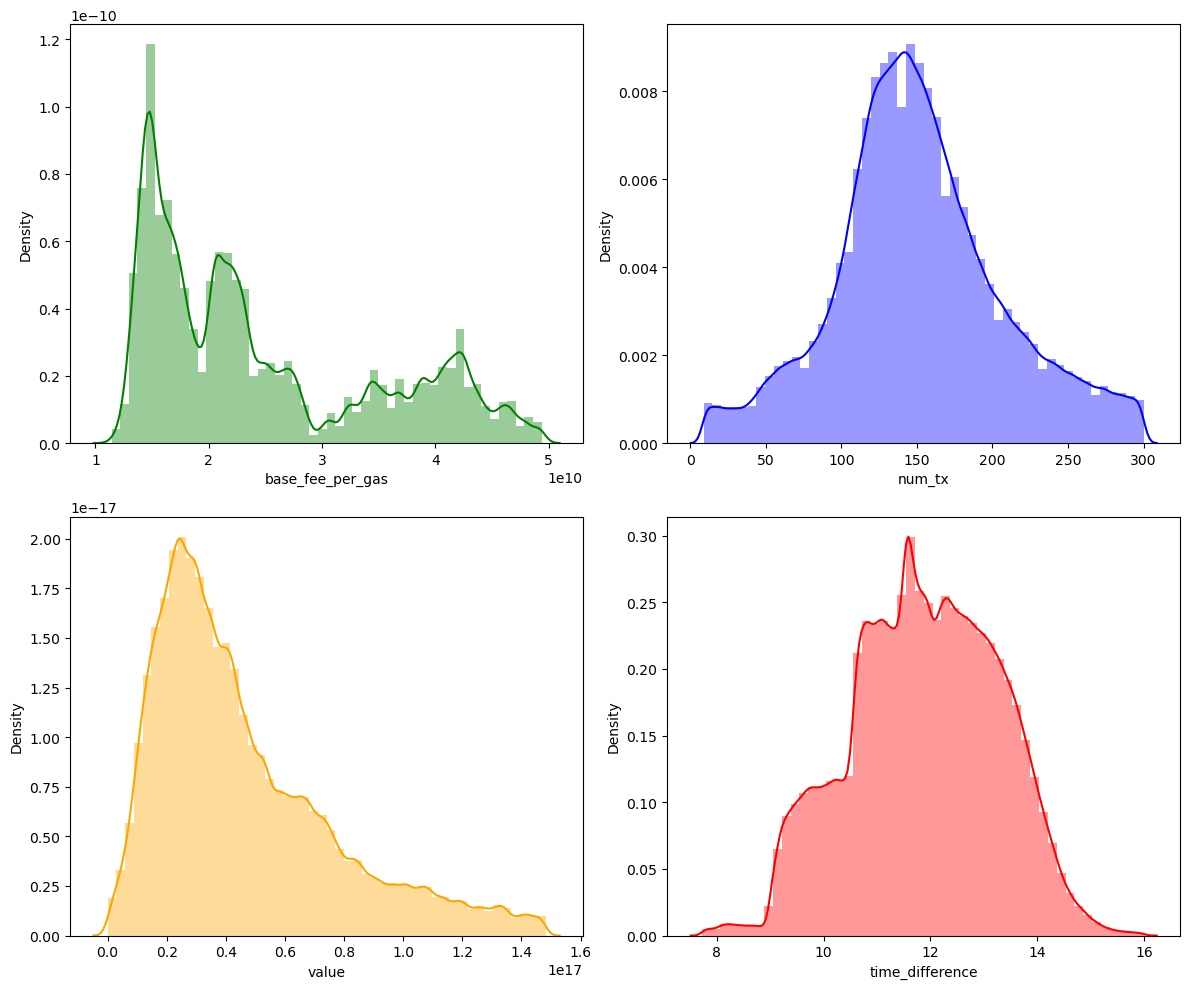

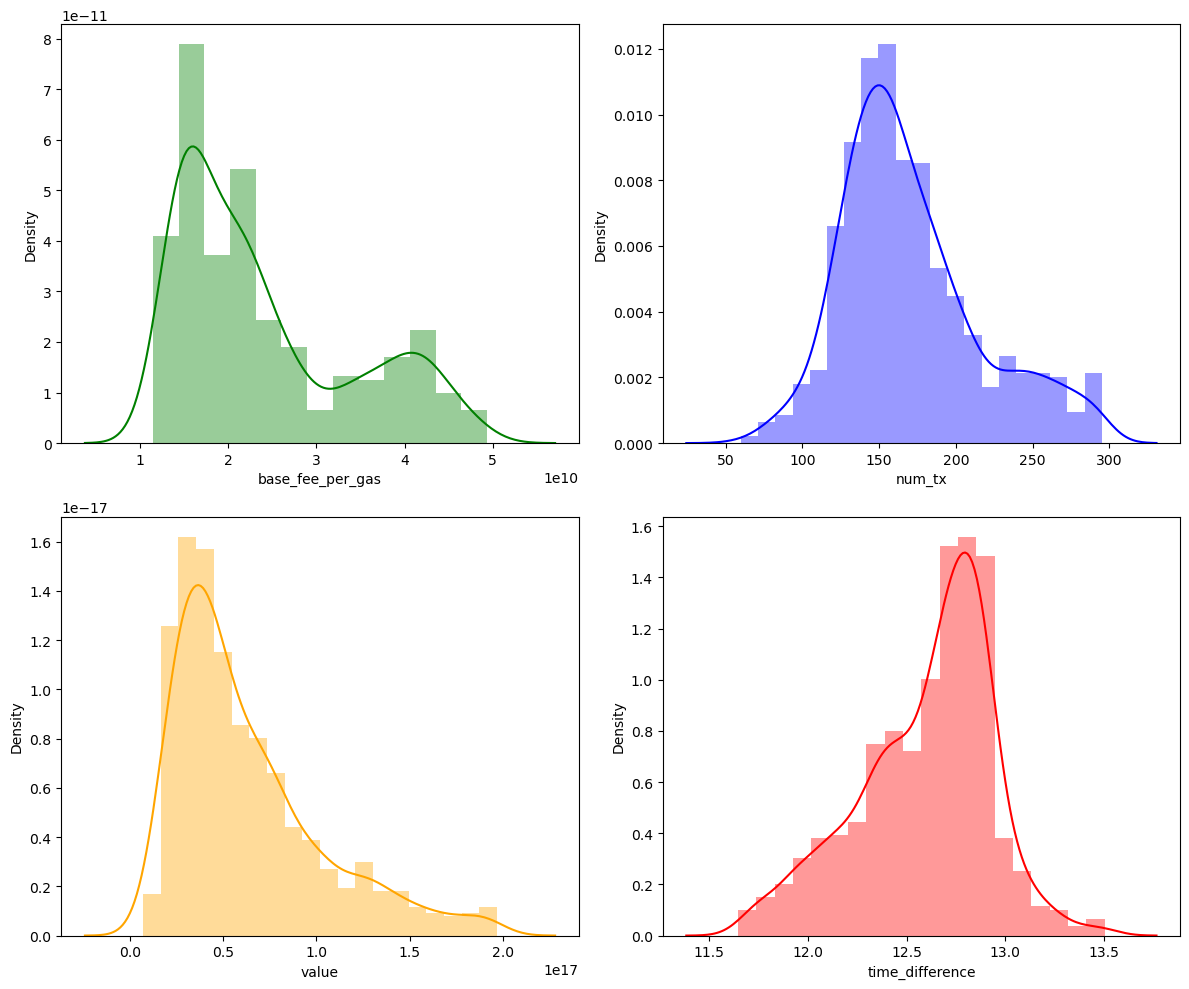

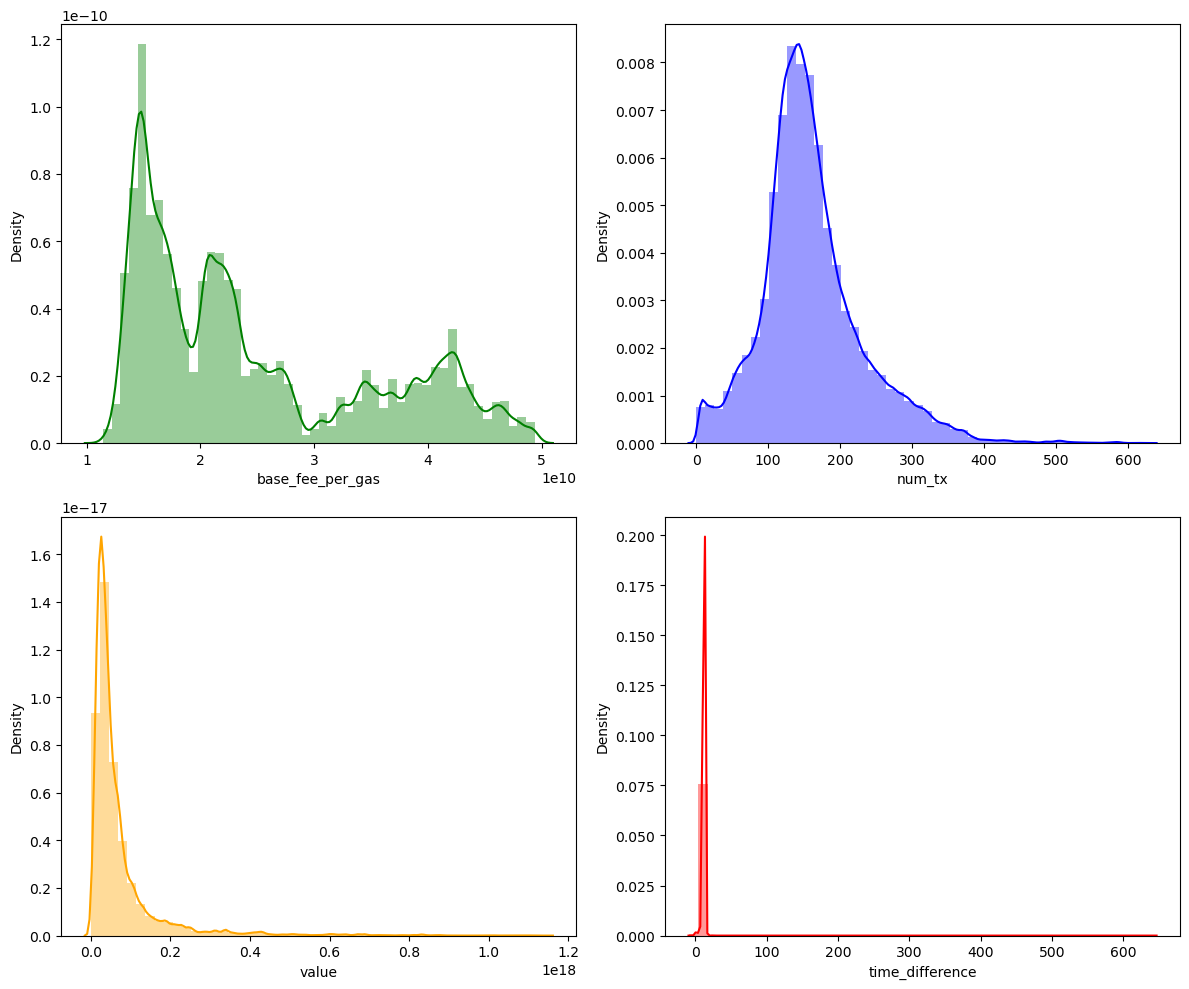

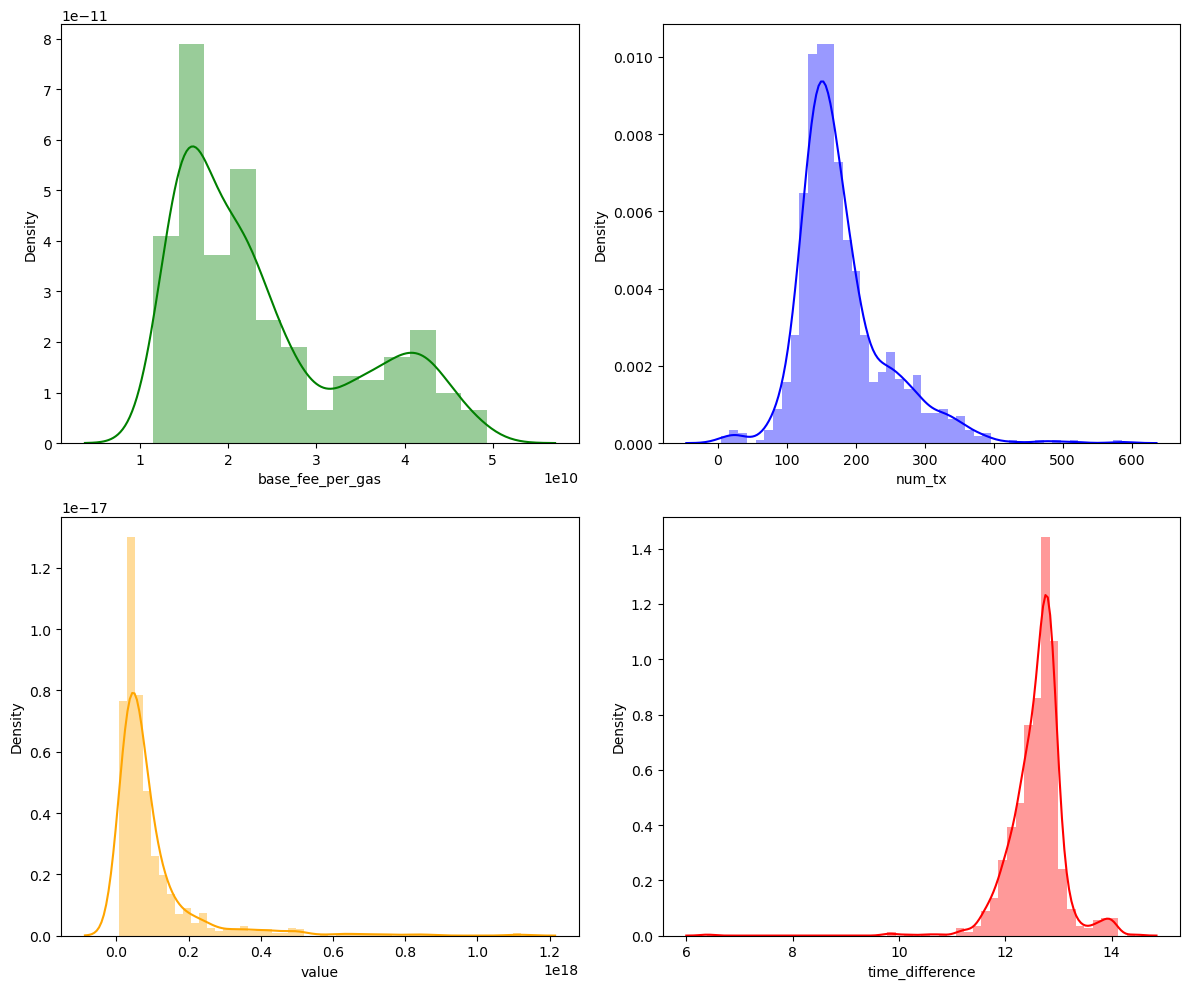

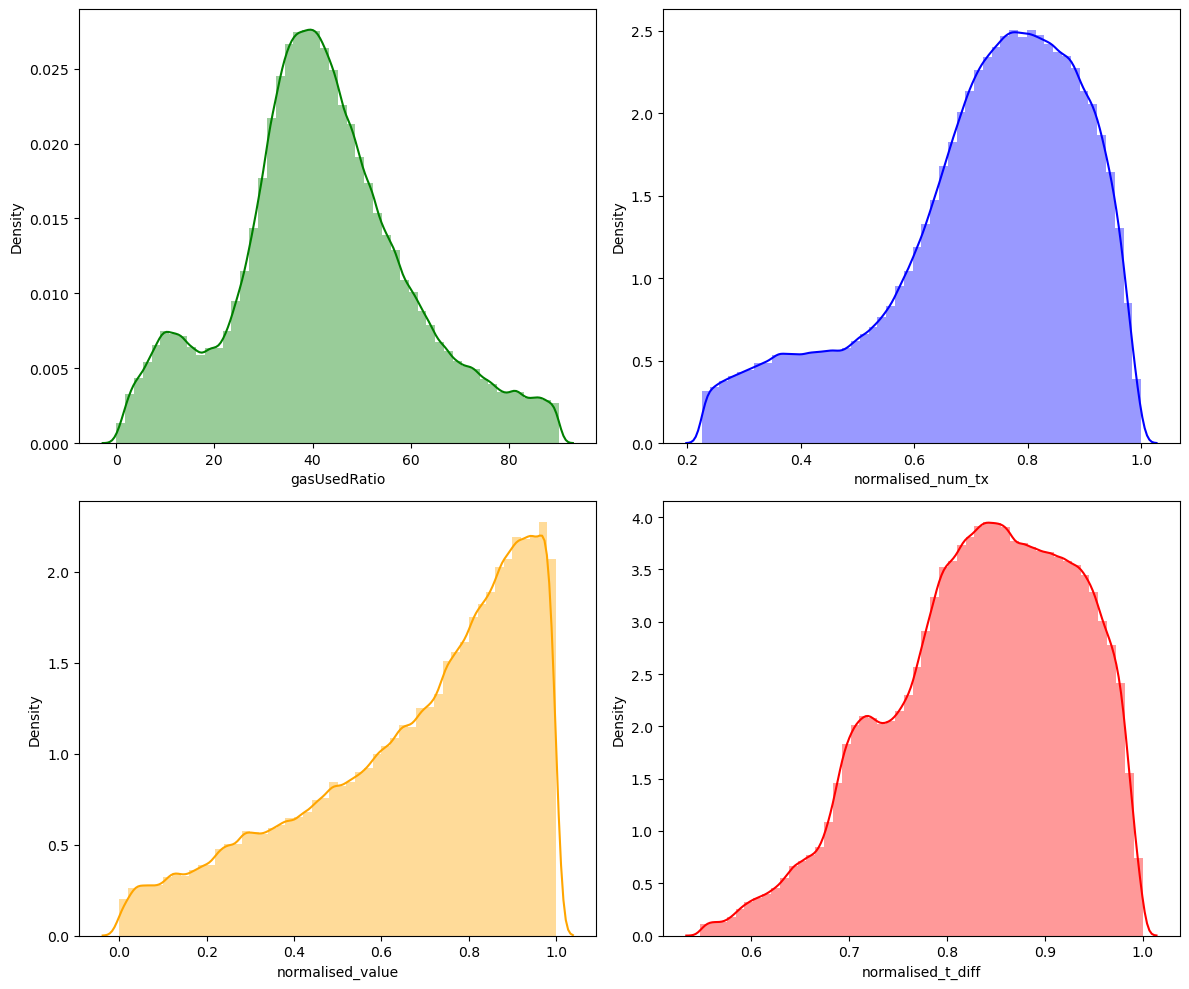

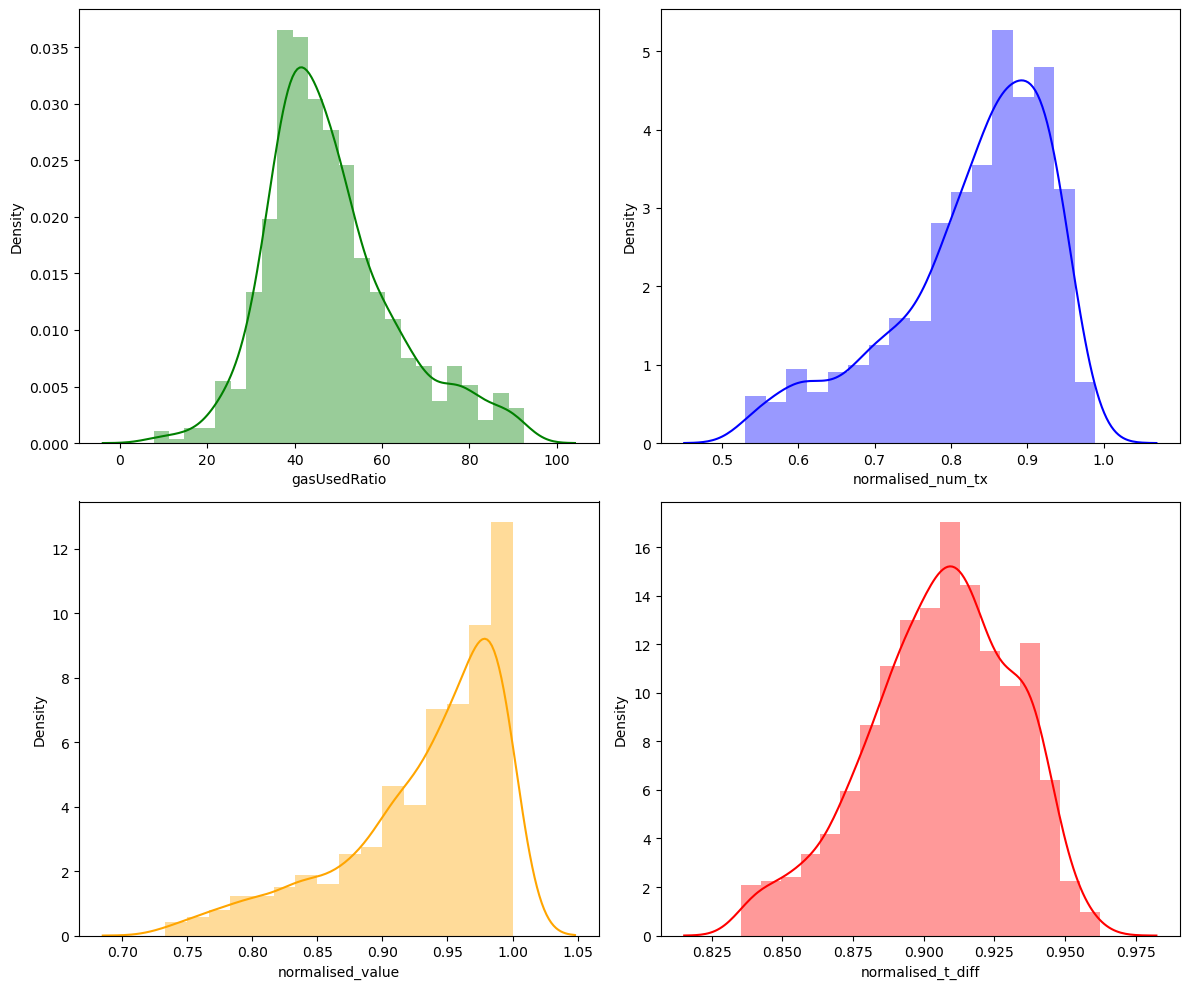

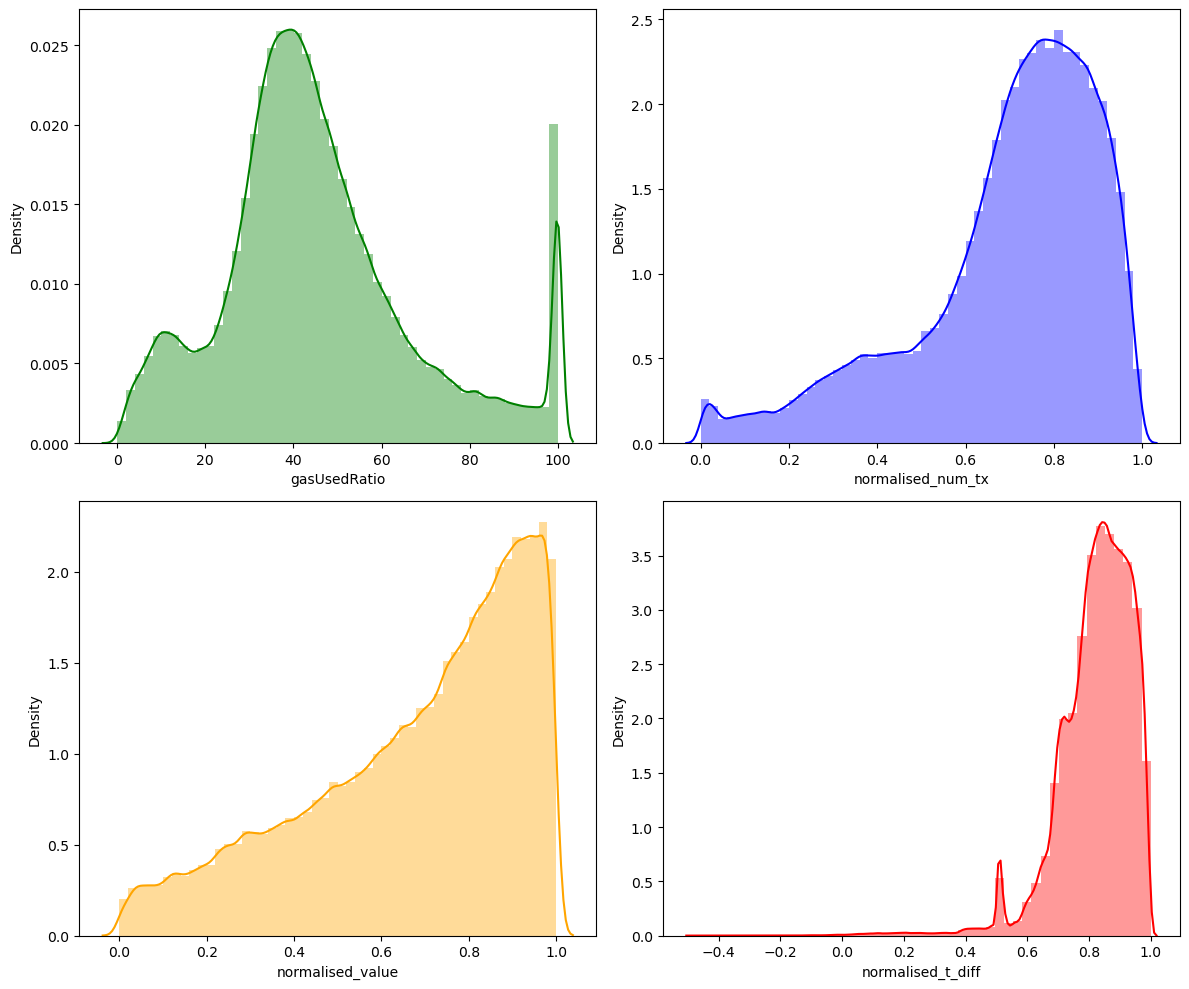

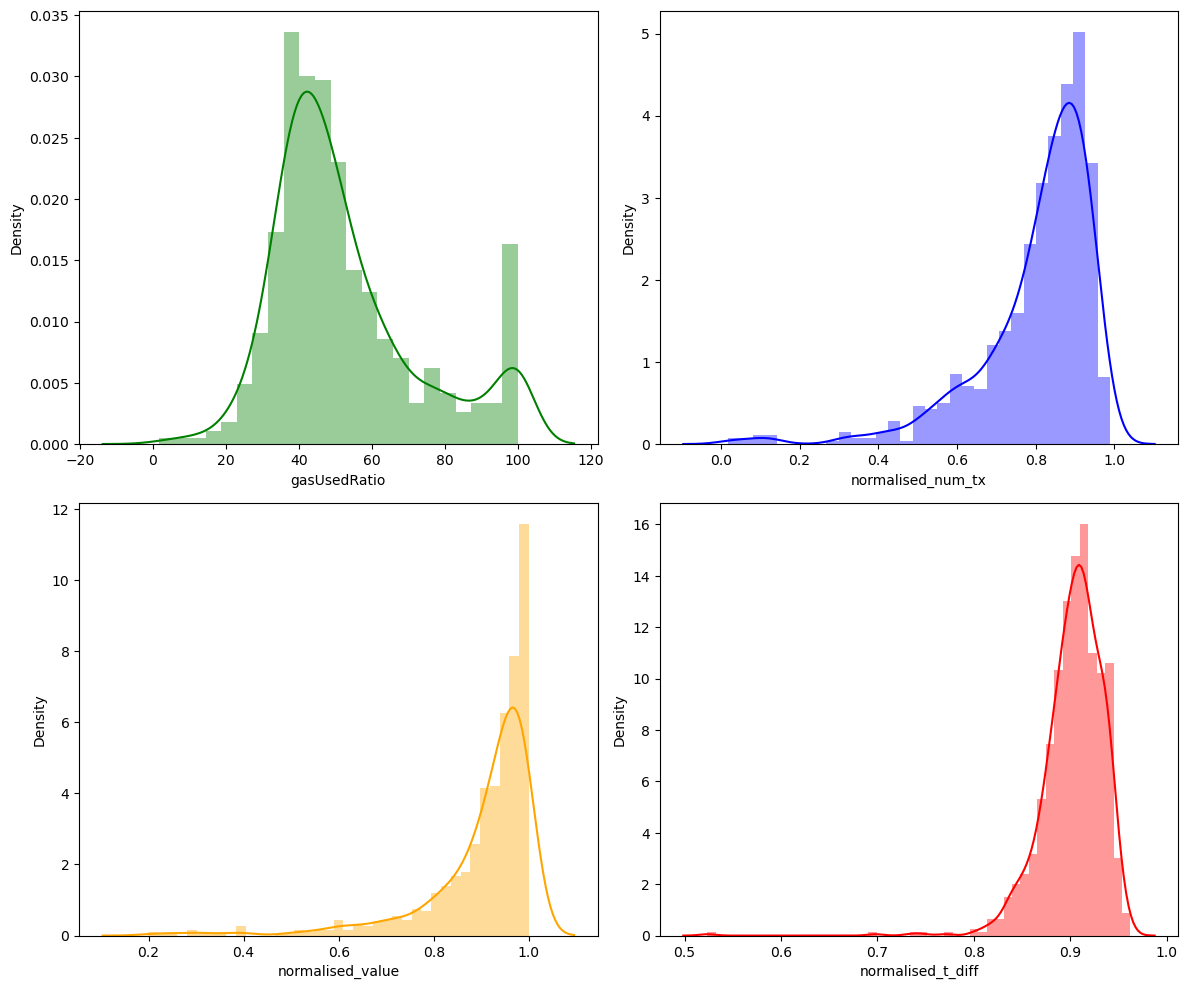

In [13]:
sns_compare ('bids', bids_df, 'base_fee_per_gas', 'num_tx', 'value', 'time_difference')#
sns_compare ('winner', matched_df, 'base_fee_per_gas', 'num_tx', 'value', 'time_difference')#
sns_outlier ('bids', bids_df, 'base_fee_per_gas', 'num_tx', 'value', 'time_difference')#
sns_outlier ('winner', matched_df, 'base_fee_per_gas', 'num_tx', 'value', 'time_difference')#

sns_compare ('normalised_bids', bids_df, 
             'gasUsedRatio', 'normalised_num_tx', 'normalised_value', 'normalised_t_diff')#
sns_compare ('normalised_winner', matched_df, 
             'gasUsedRatio', 'normalised_num_tx', 'normalised_value', 'normalised_t_diff')#
sns_outlier ('normalised_bids', bids_df, 
             'gasUsedRatio', 'normalised_num_tx', 'normalised_value', 'normalised_t_diff')#
sns_outlier ('normalised_winner', matched_df, 
             'gasUsedRatio', 'normalised_num_tx', 'normalised_value', 'normalised_t_diff')#

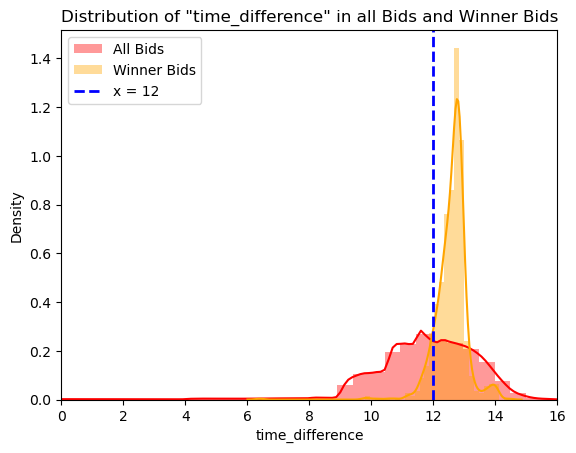

In [14]:
bids_df_filtered = bids_df[bids_df['time_difference'] <= 16]

sns.distplot(bids_df_filtered['time_difference'],color='red', label='All Bids')
sns.distplot(matched_df['time_difference'],color='orange', label = 'Winner Bids')
plt.axvline(x=12, color='blue', linestyle='--', linewidth=2, label='x = 12')
plt.legend()
plt.xlim(0, 16)

plt.title('Distribution of "time_difference" in all Bids and Winner Bids')
plt.savefig('graphs/Distribution of time_difference in all Bids and Winner Bids.png')
plt.show()#

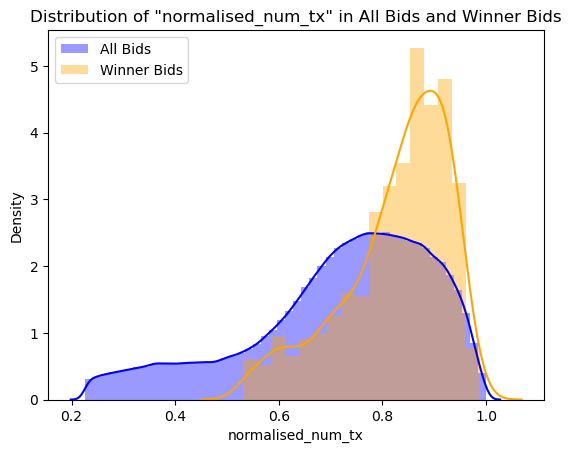

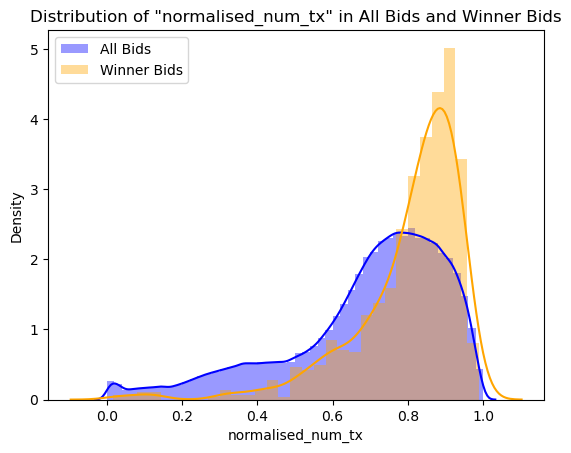

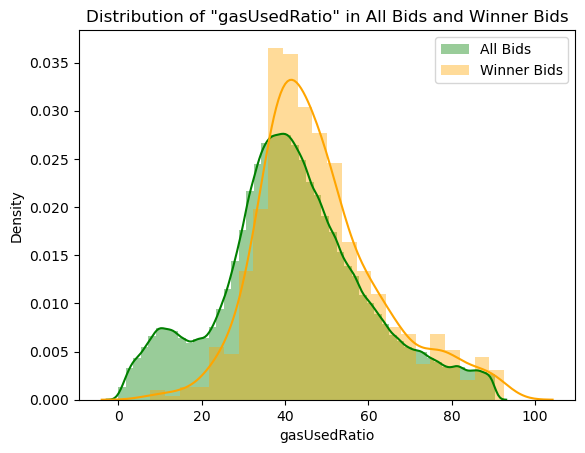

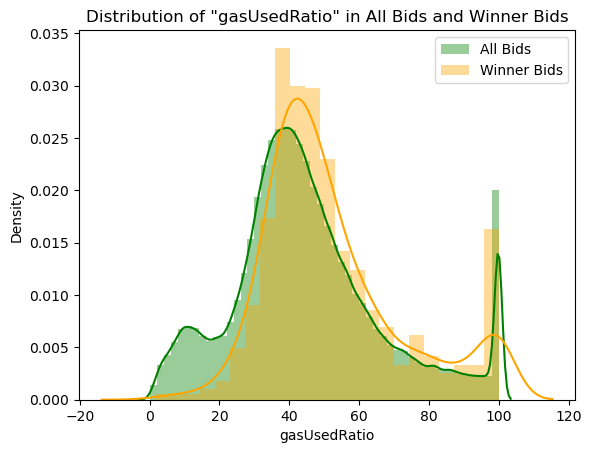

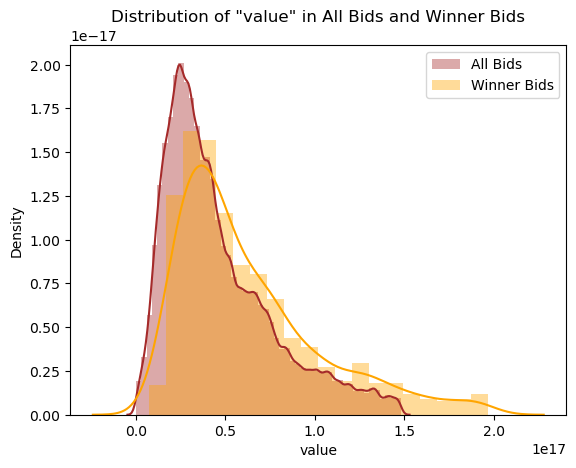

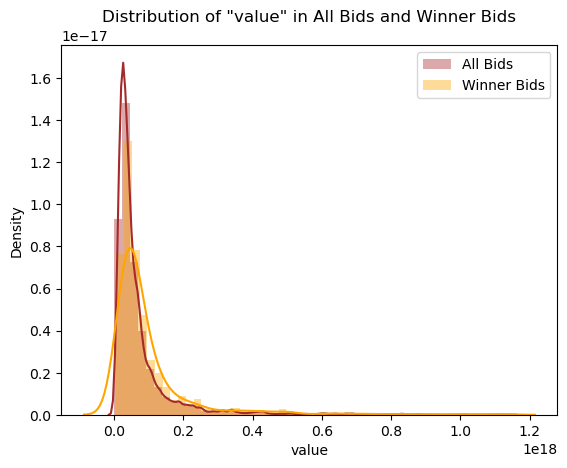

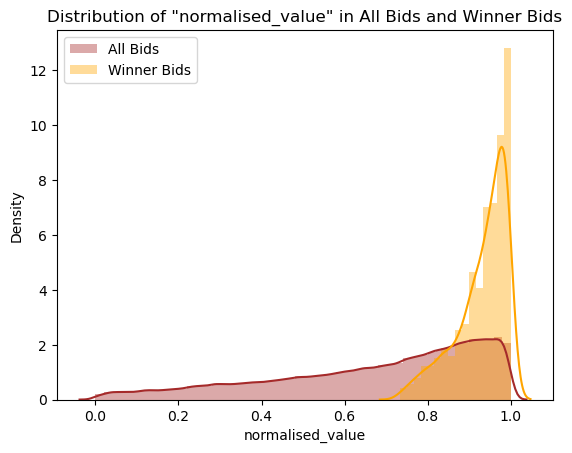

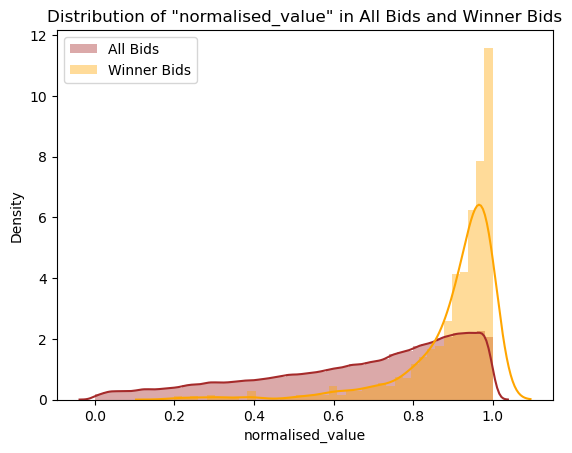

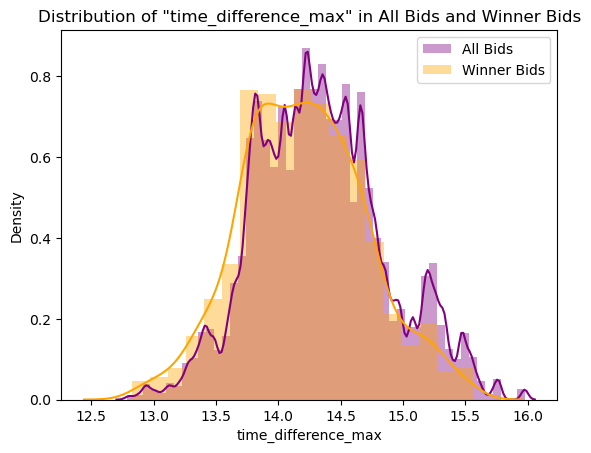

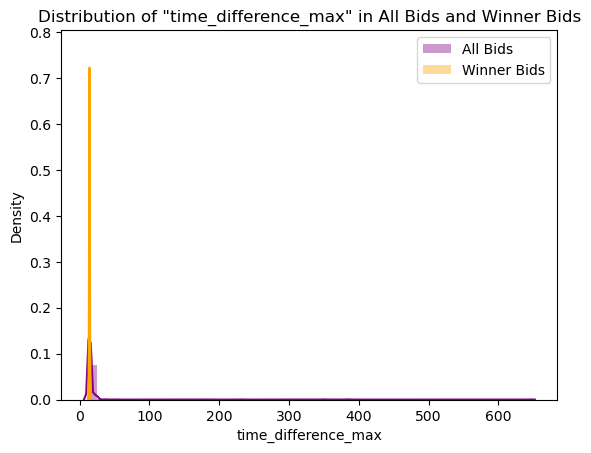

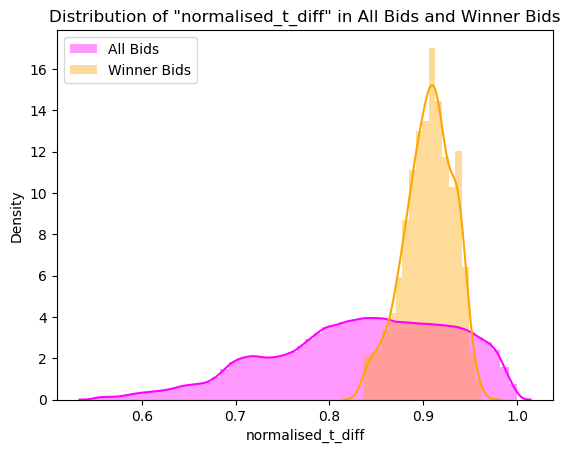

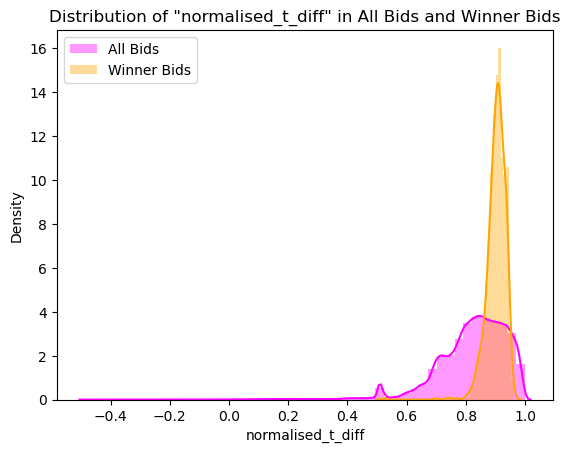

In [15]:
dist_all_vs_win('normalised_num_tx', 'blue')#
dist_outlier('normalised_num_tx', 'blue')#

dist_all_vs_win('gasUsedRatio', 'green')#
dist_outlier('gasUsedRatio', 'green')#

dist_all_vs_win('value', 'brown')#
dist_outlier('value', 'brown')#

dist_all_vs_win('normalised_value', 'brown')#
dist_outlier('normalised_value', 'brown')#

dist_all_vs_win('time_difference_max', 'purple')#
dist_outlier('time_difference_max', 'purple')#

dist_all_vs_win('normalised_t_diff', 'magenta')#
dist_outlier('normalised_t_diff', 'magenta')#

In [16]:
print("Statistics for matched_df['time_difference']:")
print(matched_df['time_difference'].describe())

print("Statistics for bids_df['time_difference']:")
print(bids_df['time_difference'].describe())

Statistics for matched_df['time_difference']:
count    903.000000
mean      12.594614
std        0.513665
min        6.397000
25%       12.368500
50%       12.677000
75%       12.851500
max       14.451000
Name: time_difference, dtype: float64
Statistics for bids_df['time_difference']:
count    3.000000e+06
mean     1.172881e+01
std      2.966656e+00
min     -9.337000e+00
25%      1.083700e+01
50%      1.185800e+01
75%      1.291400e+01
max      6.462430e+02
Name: time_difference, dtype: float64


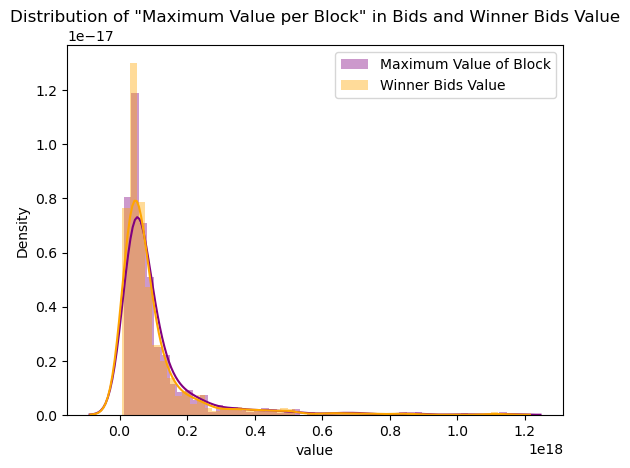

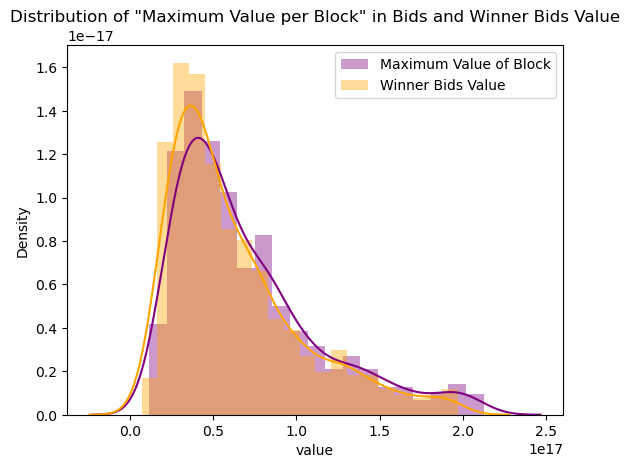

In [17]:
#
sns.distplot(matched_df['value_max'],color='purple', label='Maximum Value of Block')
sns.distplot(matched_df['value'],color='orange', label = 'Winner Bids Value')
plt.legend()

plt.title('Distribution of "Maximum Value per Block" in Bids and Winner Bids Value')
plt.savefig('graphs/Distribution of Maximum Value per Block in Bids and Winner Bids Value.png')
plt.show()#

#
df1 = remove_outliers(matched_df, 'value_max') # remove outlier
df2 = remove_outliers(matched_df, 'value')
sns.distplot(df1['value_max'],color='purple', label='Maximum Value of Block')
sns.distplot(df2['value'],color='orange', label = 'Winner Bids Value')
plt.legend()

plt.title('Distribution of "Maximum Value per Block" in Bids and Winner Bids Value')
plt.savefig('graphs/Distribution of Maximum Value per Block in Bids and Winner Bids Value (no outlier).png')
plt.show()#

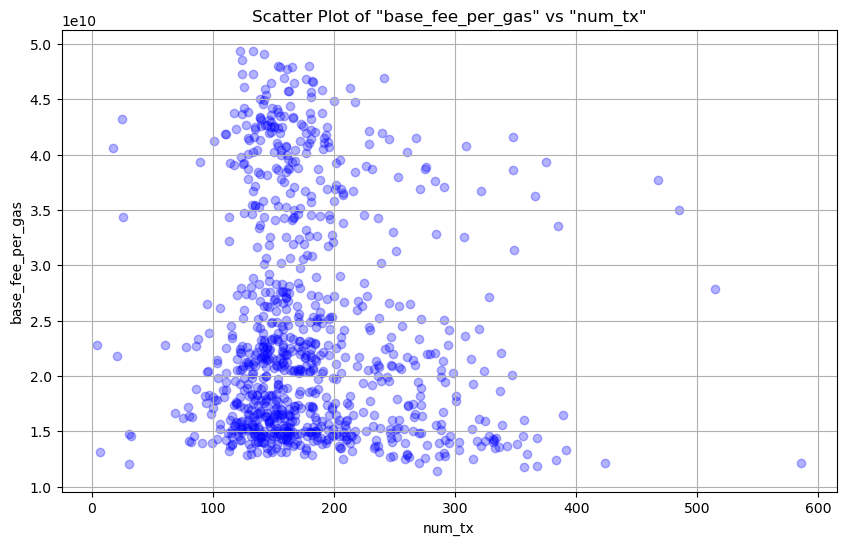

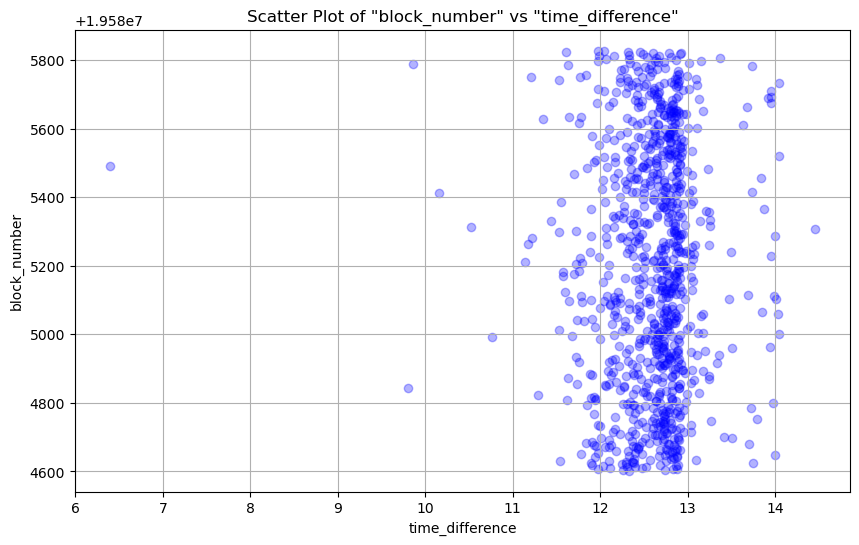

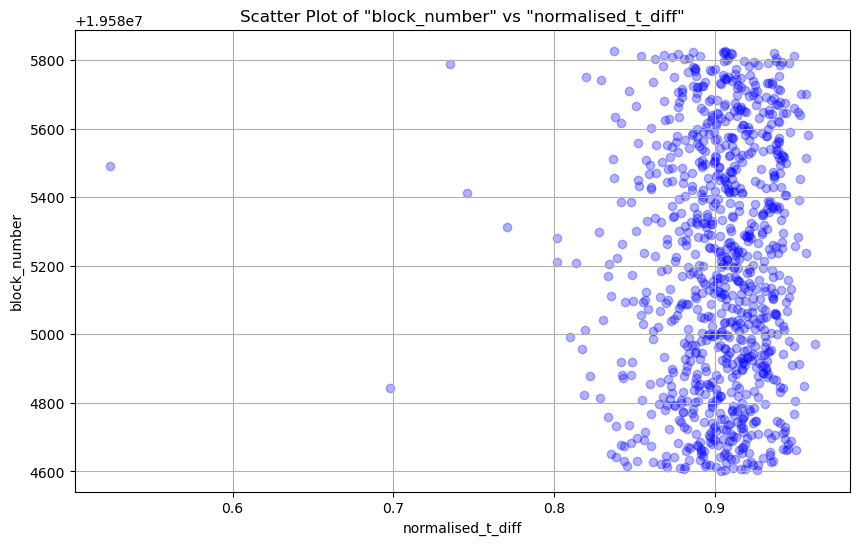

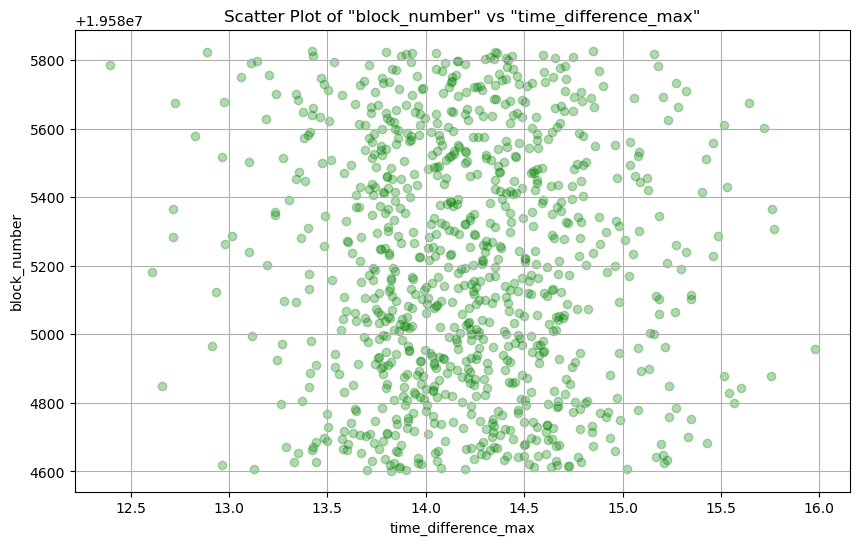

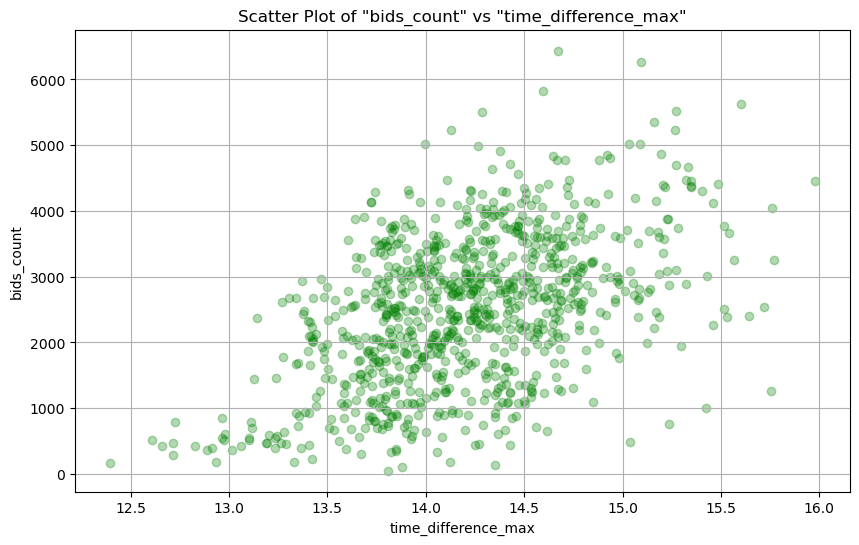

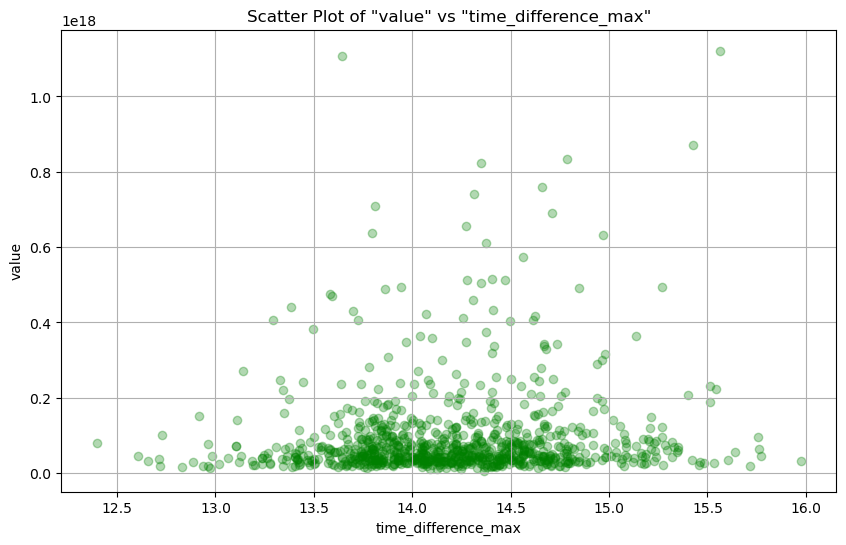

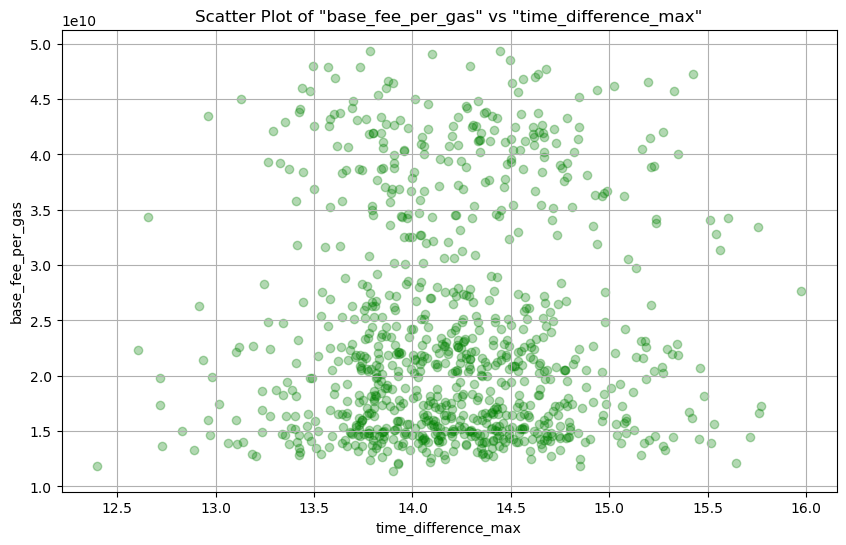

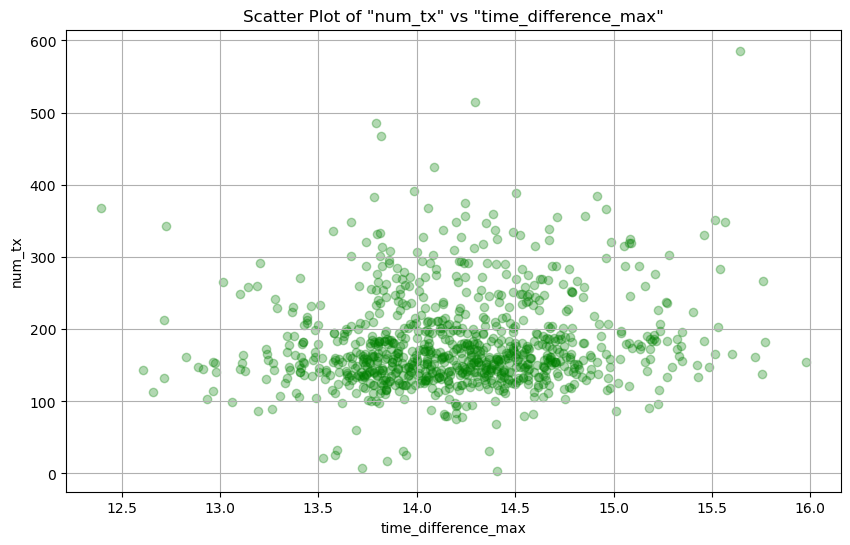

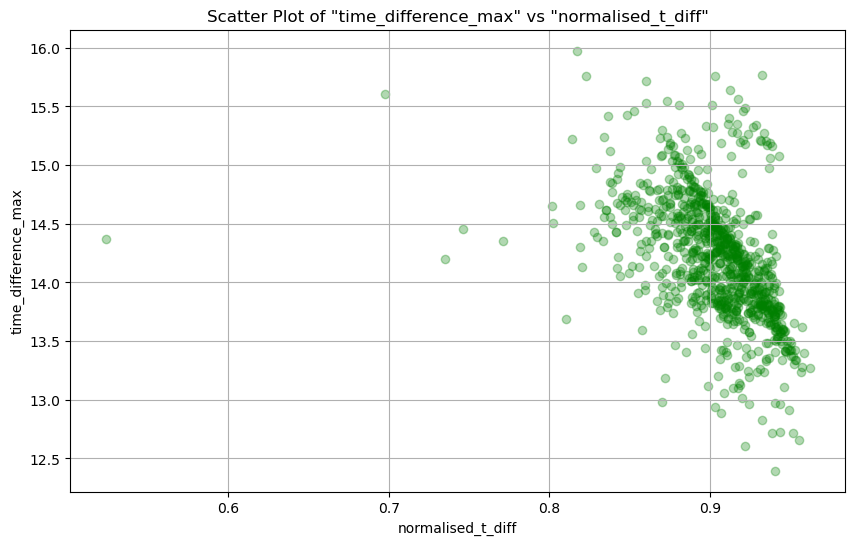

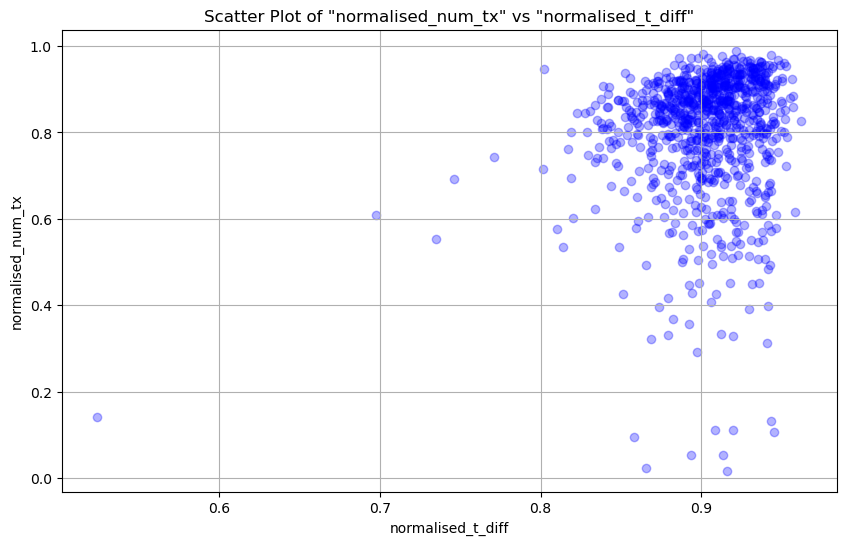

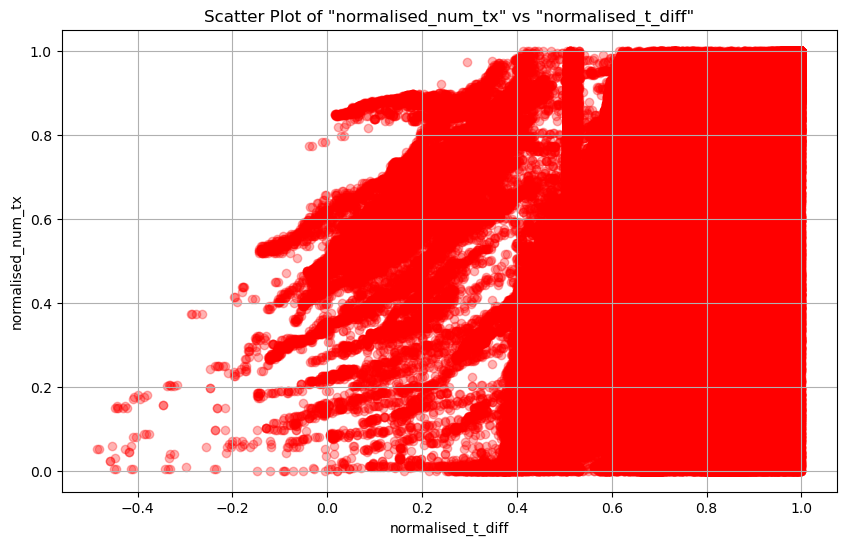

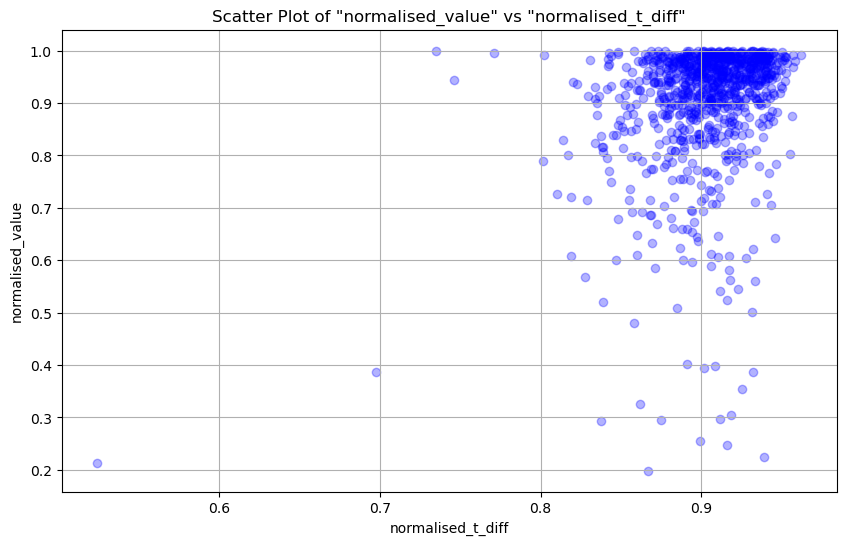

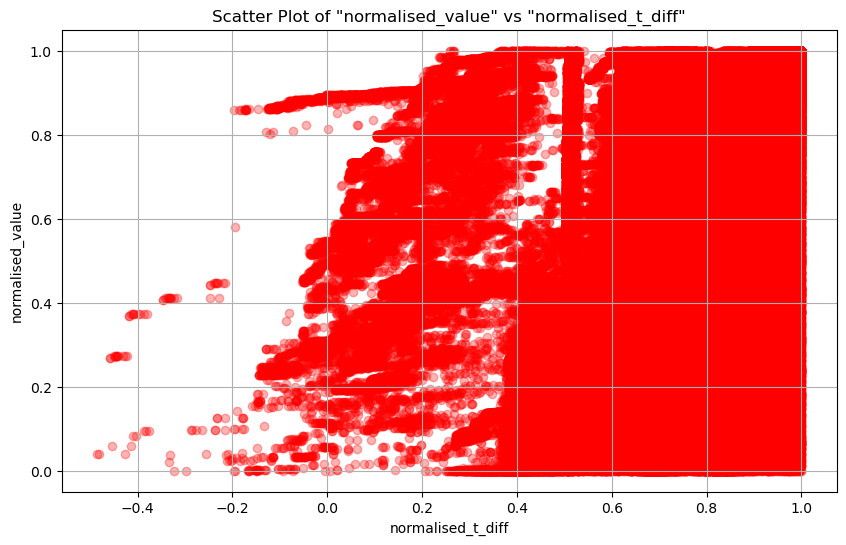

In [18]:
scatter (matched_df, 'num_tx', 'base_fee_per_gas', 'blue', 'Winner Bids')#
scatter (matched_df, 'time_difference', 'block_number', 'blue', 'Winner Bids')#
scatter (matched_df, 'normalised_t_diff', 'block_number', 'blue', 'Winner Bids')#
scatter (matched_df, 'time_difference_max', 'block_number', 'green', 'Winner Bids')#
scatter (matched_df, 'time_difference_max', 'bids_count', 'green', 'Winner Bids')#
scatter (matched_df, 'time_difference_max', 'value', 'green', 'Winner Bids')#
scatter (matched_df, 'time_difference_max', 'base_fee_per_gas', 'green', 'Winner Bids')#
scatter (matched_df, 'time_difference_max', 'num_tx', 'green', 'Winner Bids')#

scatter (matched_df, 'normalised_t_diff', 'time_difference_max', 'green', 'Winner Bids')#
scatter (matched_df, 'normalised_t_diff', 'normalised_num_tx', 'blue', 'Winner Bids')#
scatter (bids_df, 'normalised_t_diff', 'normalised_num_tx', 'red', 'All Bids')#
scatter (matched_df, 'normalised_t_diff', 'normalised_value', 'blue', 'Winner Bids')#
scatter (bids_df, 'normalised_t_diff', 'normalised_value', 'red', 'All Bids')#

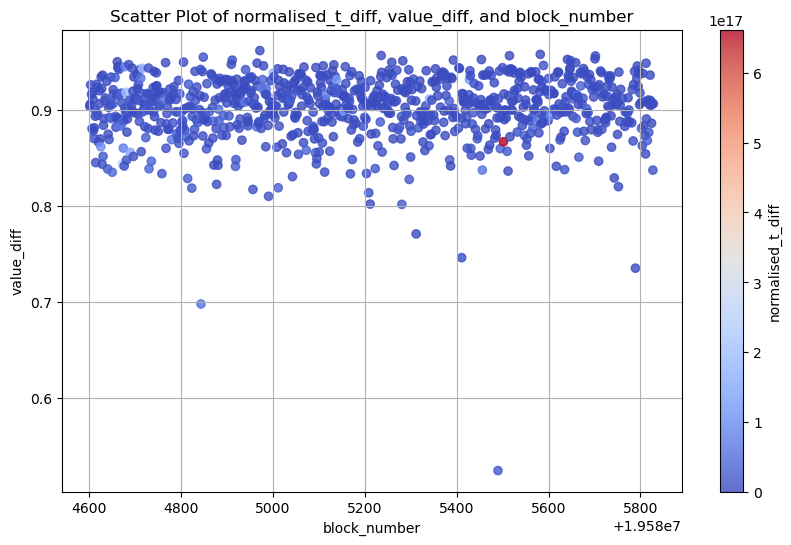

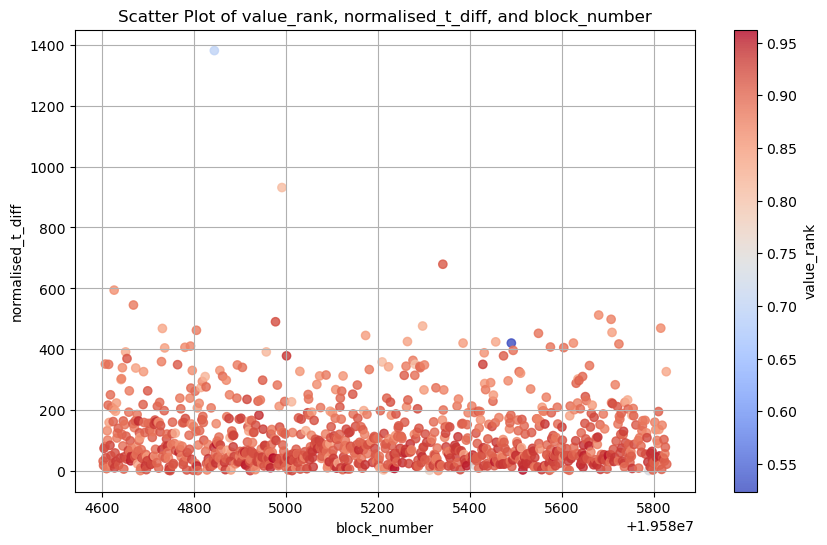

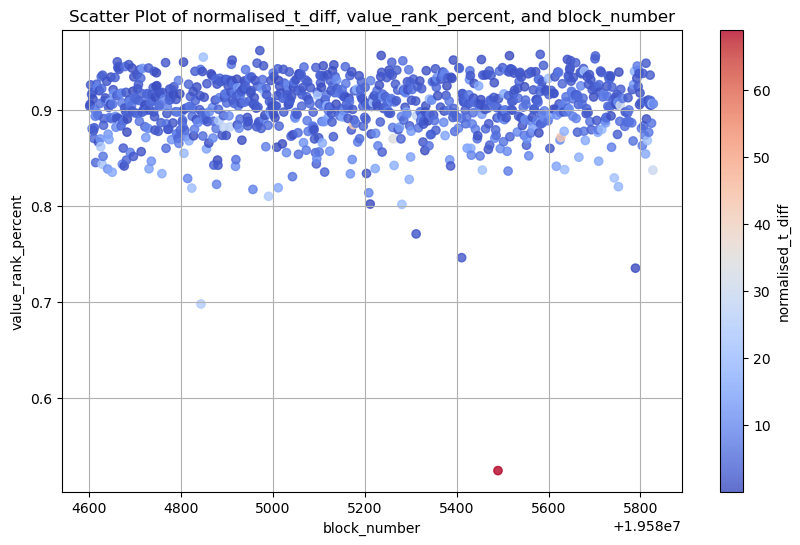

In [19]:
block_number = matched_df['block_number']
normalised_t_diff = matched_df['normalised_t_diff']
value_diff = (matched_df['value_max'] - matched_df['value'])
name = ['block_number', 'value_diff', 'normalised_t_diff']
scatter3(block_number, normalised_t_diff, value_diff, name)#


block_number = matched_df['block_number']
normalised_t_diff = matched_df['normalised_t_diff']
value_rank = matched_df['value_rank']
name = ['block_number', 'normalised_t_diff', 'value_rank']
scatter3(block_number, value_rank, normalised_t_diff, name)#


block_number = matched_df['block_number']
normalised_t_diff = matched_df['normalised_t_diff'] # also be use in density plot
value_rank_percent = matched_df['value_rank_percent'] # also be use in density plot

name = ['block_number', 'value_rank_percent', 'normalised_t_diff']
scatter3(block_number, normalised_t_diff, value_rank_percent, name)#

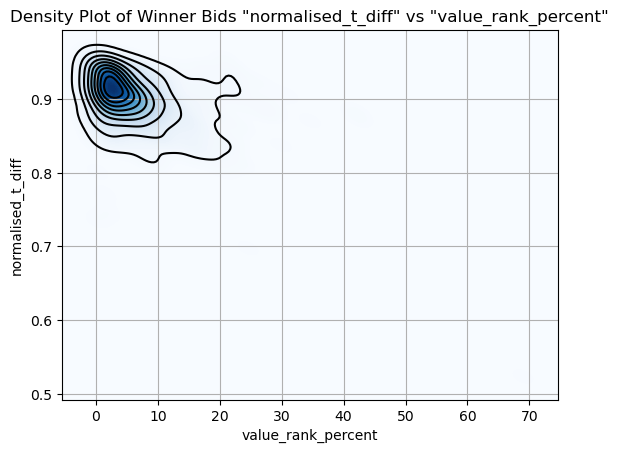

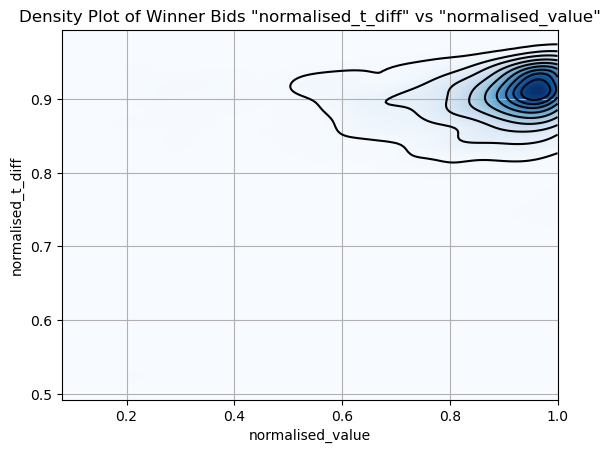

In [20]:
density(value_rank_percent , normalised_t_diff, ['value_rank_percent','normalised_t_diff'], False)#

normalised_value = matched_df['normalised_value']
normalised_t_diff = matched_df['normalised_t_diff']
density(normalised_value , normalised_t_diff, ['normalised_value','normalised_t_diff'])#

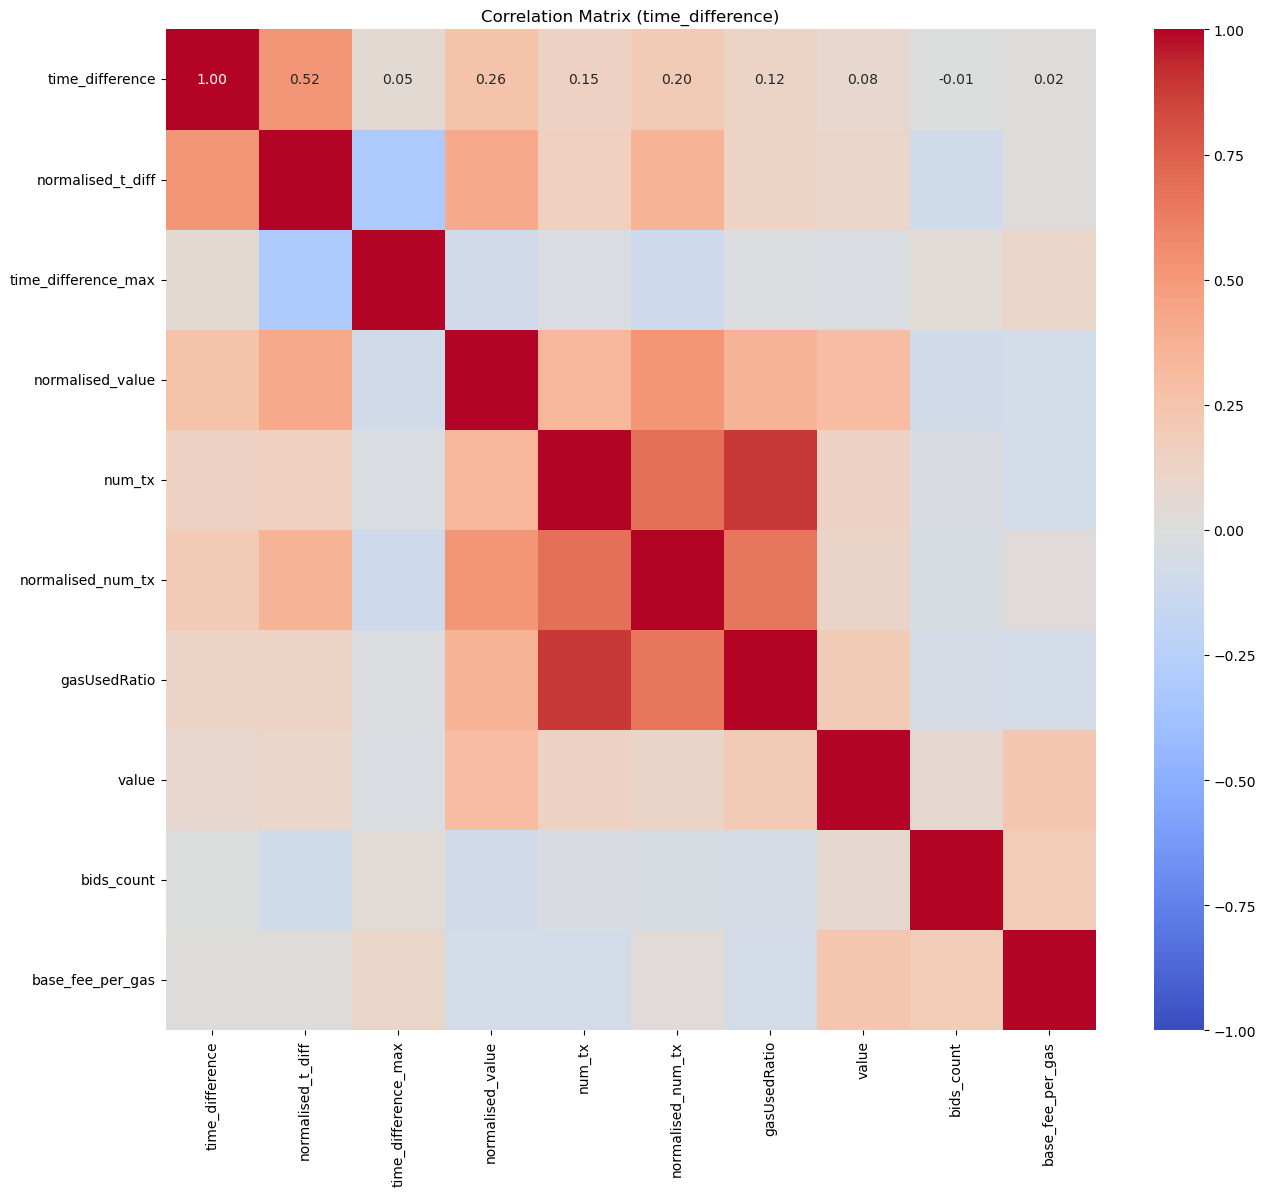

In [21]:
numeric_cols1 = ["time_difference", "normalised_t_diff", "time_difference_max",
                 "normalised_value", "num_tx", "normalised_num_tx", "gasUsedRatio", 
                 "value", "bids_count", "base_fee_per_gas"]
correlation_matrix(bids_df, numeric_cols1, 'time_difference')#

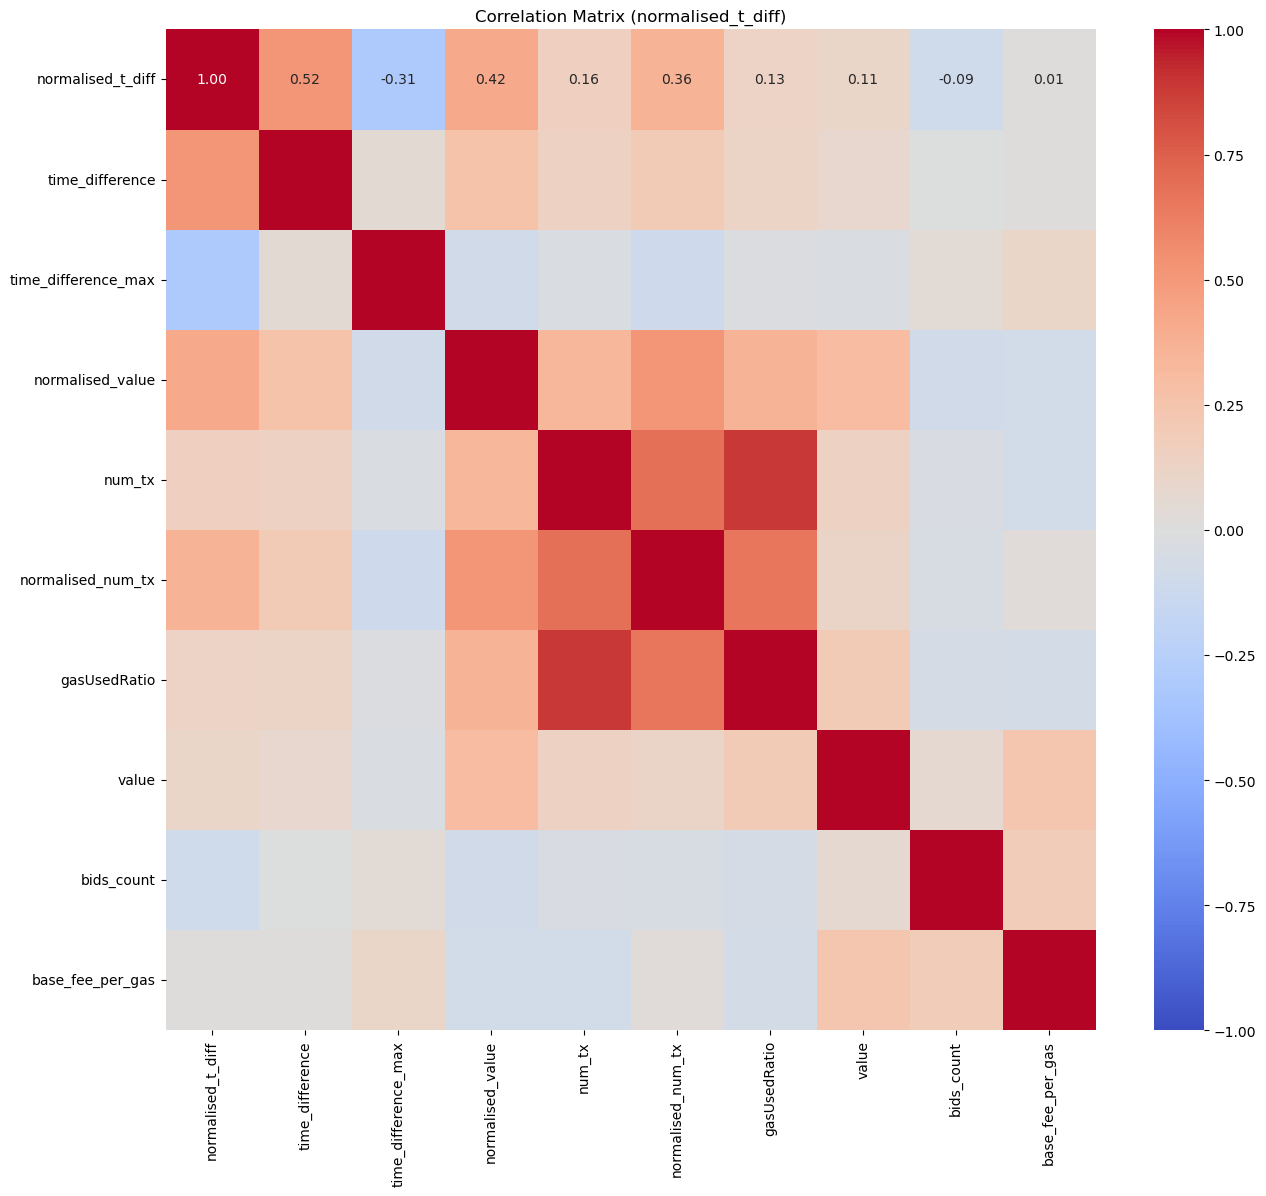

In [22]:
numeric_cols2 = ["normalised_t_diff", "time_difference", "time_difference_max", 
                 "normalised_value", "num_tx", "normalised_num_tx", "gasUsedRatio", 
                 "value", "bids_count", "base_fee_per_gas"]
correlation_matrix(bids_df, numeric_cols2, 'normalised_t_diff')#

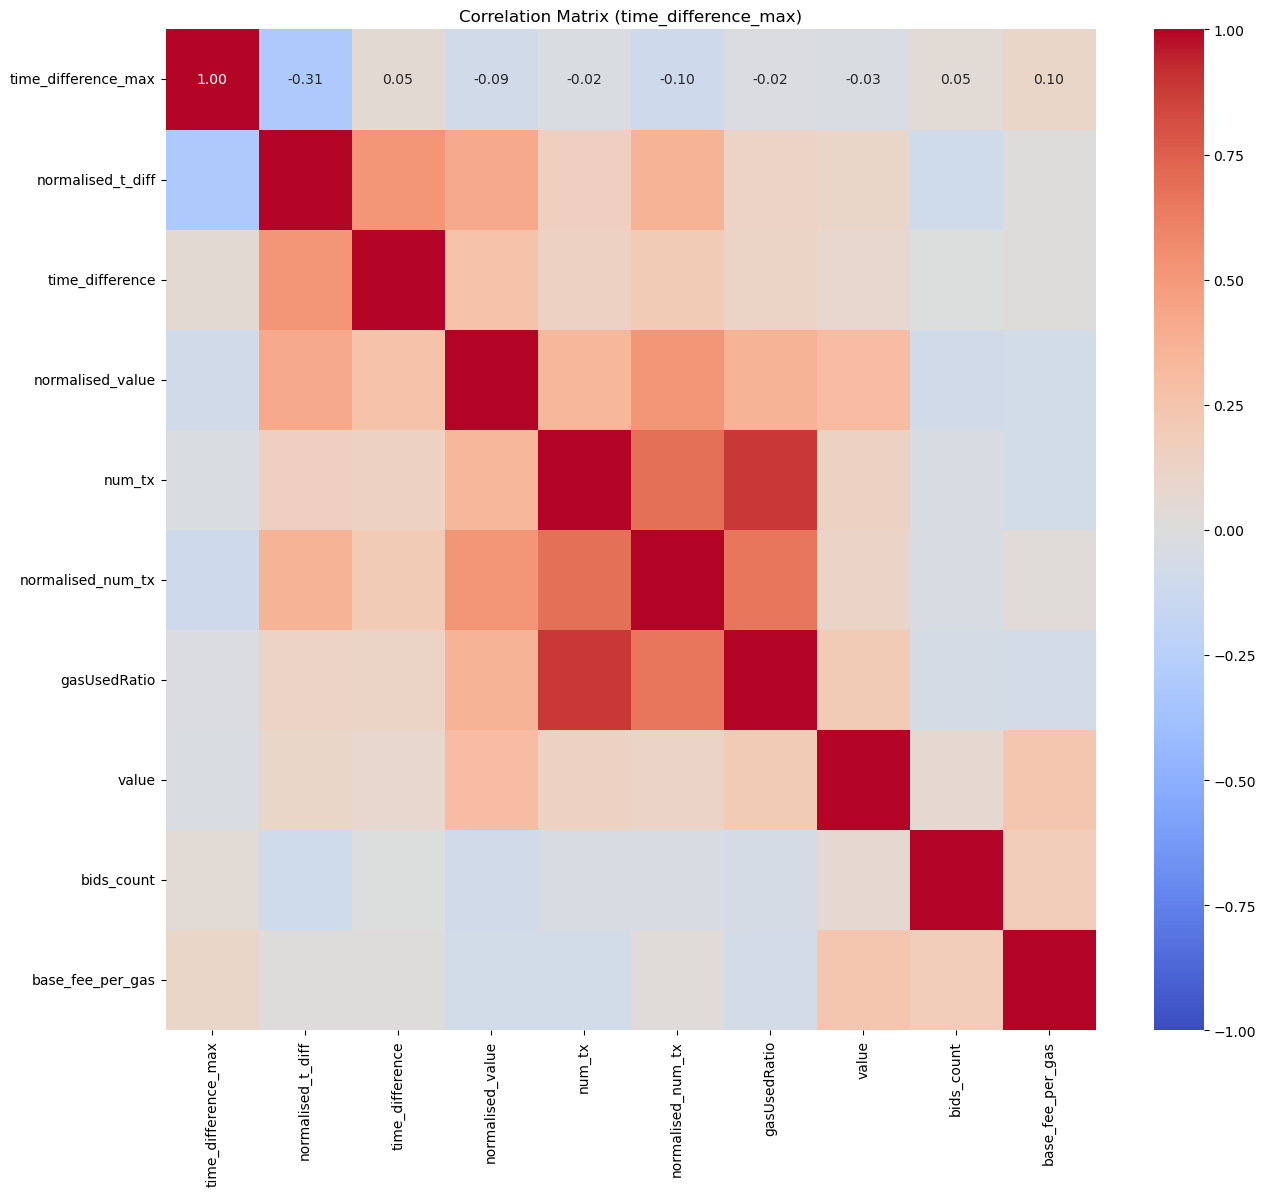

In [23]:
numeric_cols3 = ["time_difference_max", "normalised_t_diff", "time_difference", 
                 "normalised_value", "num_tx", "normalised_num_tx", "gasUsedRatio", 
                 "value", "bids_count", "base_fee_per_gas"]
correlation_matrix(bids_df, numeric_cols3, 'time_difference_max')#